In [1]:
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import math
import statistics as stat
import random

from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import ticker, patches

lblue  = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred   = (177/255,4/255,14/255)


plt.rcParams.update({
    'lines.linewidth' : 1.,
    'lines.markersize' : 5,
    'font.size': 10,
    "text.usetex": True,
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'],
    'text.latex.preamble' : r'\usepackage{amsmath,amsfonts}',
    'axes.linewidth' : .75})

In [2]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

In [3]:
def mu(Y,Z,beta):
    return (Z + beta * Y)

def sim_YZ(n, setting):
    if setting == 1:
        Z = np.random.normal(0,1,n)
        Y = np.random.normal(0,1,n)
        
    elif setting == 2:
        Z = np.random.normal(0,1,n)
        Y = Z + np.random.normal(0,1,n)
        
    elif setting == 3:
        Z = np.random.normal(0,1,n)
        Y = -Z + np.random.normal(0,1,n)
        
    return Y, Z

# Power analysis

In [4]:
nseq=np.array([500, 1000, 5000, 10000])#2**np.arange(9, 15)

In [5]:
# nseq=2**np.arange(9, 15)

In [6]:
%%time
nrep=10000; alpha=0.1 # 50 #1000

def power_analysis_sim(setting):
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))
    power   = defaultdict(lambda : defaultdict(float))
    for n in tqdm(nseq):
        eta = 1/(n**0.75)

        
        for l in range(nrep):
            Y,Z = sim_YZ(n, setting)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
            #matchings['sb']   = same_bin_matching(Y, Z, eta)
            matchings['cb']   = cross_bin_matching(Y, Z, np.floor(np.sqrt(n)))
            
            for beta, level in [(2/n, 'below'), (2/np.sqrt(n), 'at'), (1/(n**0.42), 'above')]: 
                X = mu(Y,Z,beta) + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(level, label)][n][l] = SCINT_test(X,Y,M)
        for k in pvalues:
            power[k][n] = np.mean(pvalues[k][n] < alpha)
    return(pvalues, power)

power_results = []
_, power1 = power_analysis_sim(1)
power_results.append(power1)

_, power2 = power_analysis_sim(2)
power_results.append(power2)

_, power3 = power_analysis_sim(3)
power_results.append(power3)

 50%|██████████████████████                      | 2/4 [03:44<03:44, 112.20s/it]


KeyboardInterrupt: 

In [16]:
norm.cdf(2-norm.ppf(1-alpha))

0.7637595841058832

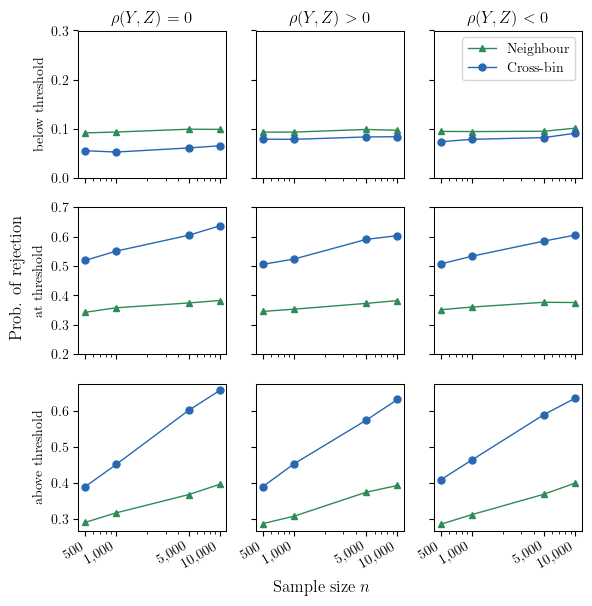

In [52]:
from matplotlib.transforms import offset_copy

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
                         sharex=True, sharey='row')

col_titles = [r'$\rho (Y,Z)$ {}'.format(col) for col in ['$=0$','$>0$','$<0$']]

levels = ['below', 'at', 'above']
row_titles = ['{} threshold'.format(row) for row in levels]


methods = [('nbhd', "Neighbour", sgreen, '^'), 
           ('cb', "Cross-bin", lblue, 'o'), 
#            ('sb', "Same bin", cred, 's'), 
          ]

for col in range(3):
    axes[0,col].set_title(col_titles[col])
    
    for row, level in enumerate(levels):
        for nm, name, color, shape in methods:
            axes[row,col].semilogx(nseq, power_results[col][(level,nm)].values(), marker=shape, 
                               linestyle='solid', c=color, label=name)

#     axes[0,col].axhline(y=alpha,c=(0,0,0),linestyle='--')
        
#     axes[1,col].axhline(y=norm.cdf(1-norm.ppf(1-alpha)),c=lblue, ls='--')
#     axes[1,col].axhline(y=norm.cdf(np.sqrt(2)-norm.ppf(1-alpha)),c=sgreen, ls='--')
#     axes[1,col].axhline(y=norm.cdf(2-norm.ppf(1-alpha)),c=sgreen, ls='--')


for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
axes[0,0].set_ylim(0,0.3)
axes[1,0].set_ylim(0.2,0.7)

lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

# axes[0,0].set_xscale('log')#, base=2)
axes[0,0].set_xticks(nseq, nseq, rotation='vertical')
axes[0,0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
axes[0,0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
for i in range(3):
    labels = axes[2,i].get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')
# axes[0,0].set_xticks(nseq, nseq, rotation=)
# axes[0,0]..tick_params(axis='x', labelrotation=90)

fig.supxlabel('Sample size $n$')
fig.supylabel('Prob. of rejection')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend(loc='upper right') #fontsize=10, 
fig.savefig('figures/power_curve_log_tall.pdf')
plt.show()

# Type I Error analysis

In [130]:
%%time
nrep=1000 # 50

def effect_on_validity():
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))

    for n in tqdm(nseq):
        eta = 1/(n**0.75)

        
        for l in range(nrep):
            Z = np.random.normal(0,1,n)
            Y = np.random.normal(0,1,n)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
            matchings['sb']   = same_bin_matching(Y, Z, eta)
            matchings['cb']   = cross_bin_matching(Y, Z, eta)
            
            for setting in range(3):
                if setting==0:
                    mu=Z
                elif setting==1:
                    mu=norm.cdf(Z)
                elif setting==2:
                    mu=10*Z
                X = mu + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(setting, label)][n][l] = SCINT_test(X,Y,M)
    return(pvalues)

results = effect_on_validity()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:59<00:00, 79.87s/it]

CPU times: user 7min 37s, sys: 20.6 s, total: 7min 57s
Wall time: 7min 59s


In [ ]:
# CPU times: user 7min 37s, sys: 20.6 s, total: 7min 57s
# Wall time: 7min 59s

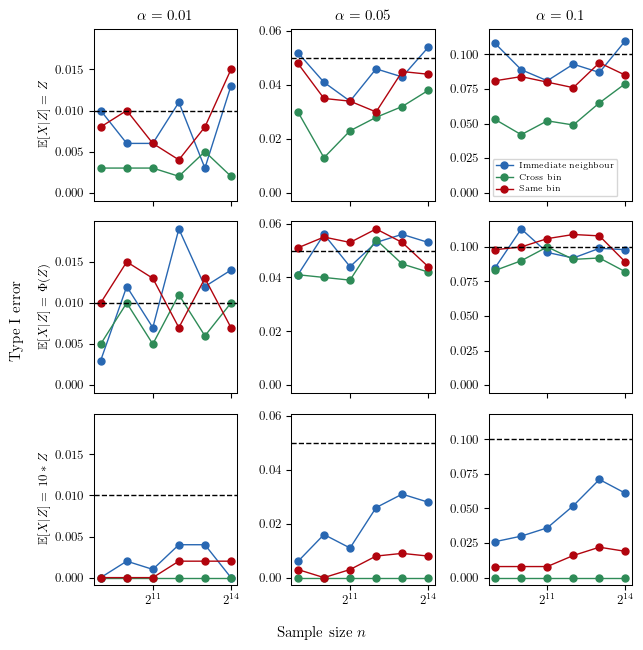

In [161]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
#                          sharex=True, sharey='col')

# alphas = [.01, .05, .1]
# col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
# row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$Z$', '$\Phi(Z)$', '$10*Z$']]

# methods = [('nbhd', "Immediate neighbour", lblue), 
#            ('cb', "Cross bin", sgreen), 
#            ('sb', "Same bin", cred), ]

# for col in range(3):
#     axes[0,col].set_title(col_titles[col])
    
#     alpha = alphas[col]
#     for row, title in enumerate(row_titles):
#         for nm, name, color in methods:
#             axes[row,col].plot(nseq, [np.mean(results[(row,nm)][n] < alpha) for n in nseq], marker='o', 
#                                linestyle='solid', c=color, label=name)
#         axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

# for row, title in enumerate(row_titles):
#     axes[row, 0].set_ylabel(title)
            
# lines = [] 
# labels = [] 
# Line, Label = axes[0,0].get_legend_handles_labels() 
# lines.extend(Line) 
# labels.extend(Label) 

# axes[0,0].set_xscale('log', base=2)
# fig.supxlabel('Sample size $n$')
# fig.supylabel('Type I error')
# # fig.legend(lines, labels, loc='right')
# axes[0,2].legend(fontsize=6)
# plt.tight_layout()
# fig.savefig('figures/validity_curve_log_tall.png')
# plt.show()

# $10,000$ reps

In [20]:
nseq

array([  500,  1000,  5000, 10000])

In [6]:
%%time
nrep=1000#0 # 50

def effect_on_validity():
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))

    for n in tqdm(nseq):
        eta = 1/(n**0.75)

        
        for l in range(nrep):
            Z = np.random.normal(0,1,n)
            Y = np.random.normal(0,1,n)
            eta = 1/(n**0.75)

            matchings = {}
            matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
#             matchings['sb']   = same_bin_matching(Y, Z, eta)
            matchings['cb']   = cross_bin_matching(Y, Z, eta)
            
            for setting in range(3):
                if setting==0:
                    mu=Z
                elif setting==1:
                    mu=norm.cdf(Z)
                elif setting==2:
                    mu=10*Z
                X = mu + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(setting, label)][n][l] = SCINT_test(X,Y,M)
    return(pvalues)

results = effect_on_validity()

100%|█████████████████████████████████████████████████████████████████| 4/4 [03:03<00:00, 45.95s/it]

CPU times: user 2min 56s, sys: 7.26 s, total: 3min 3s
Wall time: 3min 3s


In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
                         sharex=True, sharey='col')

alphas = [.01, .05, .1]
col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$Z$', '$\Phi(Z)$', '$10*Z$']]

methods = [('nbhd', "Neighbour", sgreen, '^'), 
           ('cb', "Cross bin", lblue, 'o'), 
#            ('sb', "Same bin", cred), 
          ]

for col in range(3):
    axes[0,col].set_title(col_titles[col])
    
    alpha = alphas[col]
    for row, title in enumerate(row_titles):
        for nm, name, color, shape in methods:
            axes[row,col].plot(nseq, [np.mean(results[(row,nm)][n] < alpha) for n in nseq], marker=shape, 
                               linestyle='solid', c=color, label=name)
        axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

axes[0,0].set_xscale('log')#, base=2)
axes[0,0].set_xticks(nseq, nseq, rotation='vertical')
axes[0,0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
axes[0,0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
for i in range(3):
    labels = axes[2,i].get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')
    
fig.supxlabel('Sample size $n$')
# fig.supylabel('Type I error')
fig.supylabel('Prob. of rejection')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend()
plt.tight_layout()
# fig.savefig('figures/validity_curve_log_tall-nrep=%d.png' % nrep )
plt.show()

NameError: name 'results' is not defined

Error in callback <function _draw_all_if_interactive at 0x12ccbe480> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 650x650 with 9 Axes>

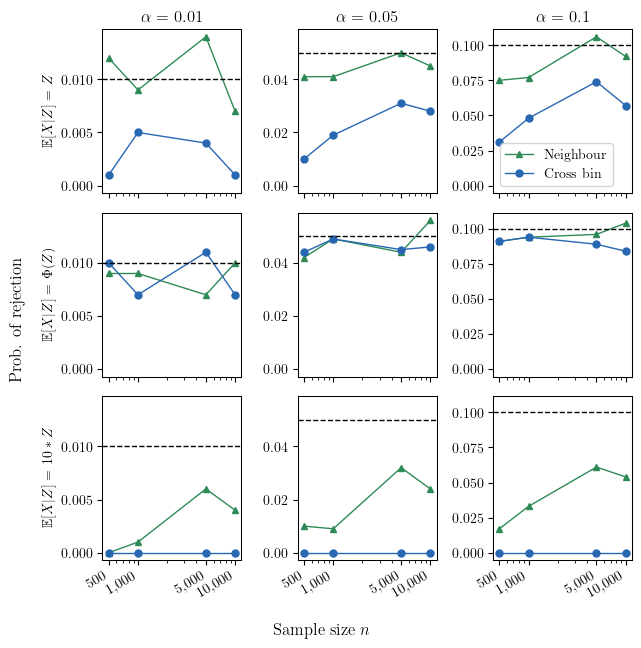

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
                         sharex=True, sharey='col')

alphas = [.01, .05, .1]
col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$Z$', '$\Phi(Z)$', '$10*Z$']]

methods = [('nbhd', "Neighbour", sgreen, '^'), 
           ('cb', "Cross bin", lblue, 'o'), 
#            ('sb', "Same bin", cred), 
          ]

for col in range(3):
    axes[0,col].set_title(col_titles[col])
    
    alpha = alphas[col]
    for row, title in enumerate(row_titles):
        for nm, name, color, shape in methods:
            axes[row,col].plot(nseq, [np.mean(results[(row,nm)][n] < alpha) for n in nseq], marker=shape, 
                               linestyle='solid', c=color, label=name)
        axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

axes[0,0].set_xscale('log')#, base=2)
axes[0,0].set_xticks(nseq, nseq, rotation='vertical')
axes[0,0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
axes[0,0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
for i in range(3):
    labels = axes[2,i].get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')
    
fig.supxlabel('Sample size $n$')
# fig.supylabel('Type I error')
fig.supylabel('Prob. of rejection')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend()
plt.tight_layout()
# fig.savefig('figures/validity_curve_log_tall-nrep=%d.png' % nrep )
plt.show()

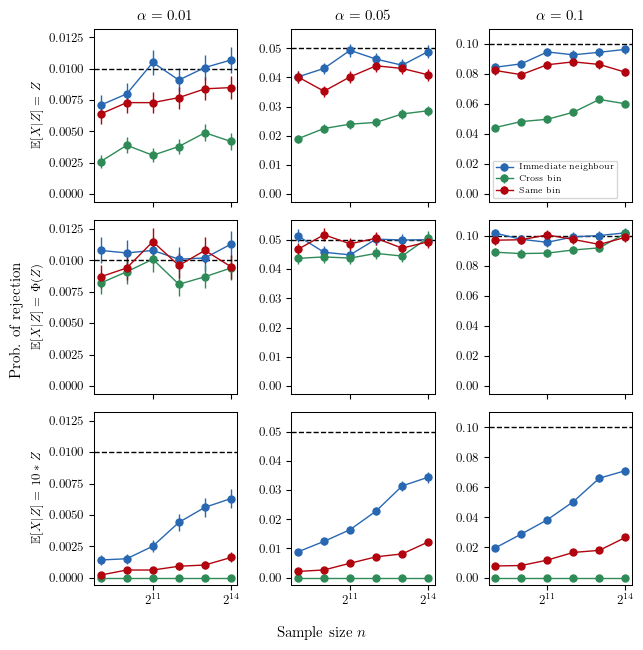

In [167]:
#  fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6.5, 6.5), # 4.875
#                          sharex=True, sharey='col')

# alphas = [.01, .05, .1]
# col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
# row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$Z$', '$\Phi(Z)$', '$10*Z$']]

# methods = [('nbhd', "Immediate neighbour", lblue), 
#            ('cb', "Cross bin", sgreen), 
#            ('sb', "Same bin", cred), ]

# for col in range(3):
#     axes[0,col].set_title(col_titles[col])
    
#     alpha = alphas[col]
#     for row, title in enumerate(row_titles):
#         for nm, name, color in methods:
#             mid = [np.mean(results[(row,nm)][n] < alpha) for n in nseq]
#             yerr = [np.std(results[(row,nm)][n] < alpha)/np.sqrt(nrep) for n in nseq]
#             axes[row,col].errorbar(nseq, mid, yerr, marker='o', 
#                                linestyle='solid', c=color, label=name)
#         axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

# for row, title in enumerate(row_titles):
#     axes[row, 0].set_ylabel(title)
            
# lines = [] 
# labels = [] 
# Line, Label = axes[0,0].get_legend_handles_labels() 
# lines.extend(Line) 
# labels.extend(Label) 

# axes[0,0].set_xscale('log', base=2)
# fig.supxlabel('Sample size $n$')
# # fig.supylabel('Type I error')
# fig.supylabel('Prob. of rejection')
# # fig.legend(lines, labels, loc='right')
# axes[0,2].legend(fontsize=6)
# plt.tight_layout()
# fig.savefig('figures/validity_curve_errors_log_tall-nrep=%d.png' % nrep )
# plt.show()

# Validity as a function of strength of monotonicity in $X\mid Z$

In [47]:
%%time
nrep = 1000000
# nrep=10000 

gamma_seq = [.1, 1, 10]
n = 500
eta = 1/(n**0.75)

def effect_on_validity():
    pvalues = defaultdict(lambda : defaultdict(lambda : np.zeros(nrep)))
        
    for l in range(nrep):
        if l%10000==0: print(l/10000)
        Z = np.random.normal(0,1,n)
        Y = np.random.normal(0,1,n)
        eta = 1/(n**0.75)

        matchings = {}
        matchings['nbhd'] = immediate_neighbor_matching(Y, Z)
        matchings['cb']   = cross_bin_matching(Y, Z, eta)

        for gamma in gamma_seq:
            for setting in range(2):
                if setting==0:
                    mu=gamma*Z
                elif setting==1:
                    mu=norm.cdf(gamma*Z)
                X = mu + np.random.normal(0,1,n)
                for label, M in matchings.items():
                    pvalues[(setting, label)][gamma][l] = SCINT_test(X,Y,M)
    return(pvalues)

results = effect_on_validity()

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
CPU times: user 1h 55min 36s, sys: 2min 1s, total: 1h 57min 38s
Wall time: 1h 58min 42s


1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000


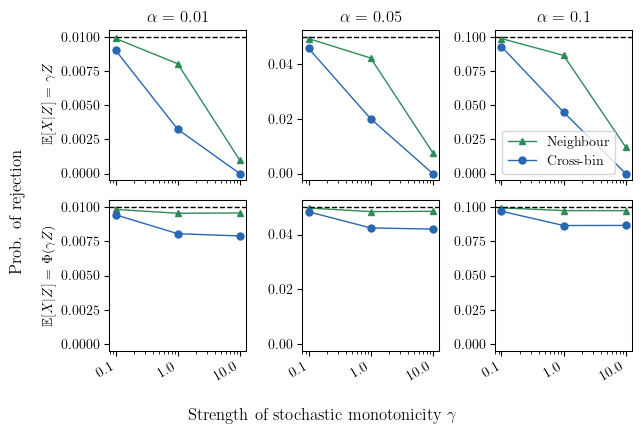

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6.5, 6.5*2/3), # 4.875
                         sharex=True, sharey='col')

alphas = [.01, .05, .1]
col_titles = [r'$\alpha=$ {}'.format(col) for col in ['$0.01$','$0.05$','$0.1$']]
row_titles = [r'$\mathbb E[X|Z]=$ {}'.format(row) for row in ['$\\gamma Z$', '$\Phi(\\gamma Z)$']]

methods = [('nbhd', "Neighbour", sgreen, '^'), 
           ('cb', "Cross-bin", lblue, 'o'), 
#            ('sb', "Same bin", cred), 
          ]

for col in range(3):
    axes[0,col].set_title(col_titles[col])
    
    alpha = alphas[col]
    for row, title in enumerate(row_titles):
        for nm, name, color, shape in methods:
            print(len(results[(row,nm)][.1] < alpha))
            axes[row,col].plot(gamma_seq, [np.mean(results[(row,nm)][gamma] < alpha) for gamma in gamma_seq], marker=shape, 
                               linestyle='solid', c=color, label=name)
        axes[row,col].axhline(y=alpha,c=(0,0,0),linestyle='--')

for row, title in enumerate(row_titles):
    axes[row, 0].set_ylabel(title)
            
lines = [] 
labels = [] 
Line, Label = axes[0,0].get_legend_handles_labels() 
lines.extend(Line) 
labels.extend(Label) 

axes[0,0].set_xscale('log')#, base=2)
axes[0,0].set_xticks(gamma_seq, gamma_seq, rotation='vertical')
axes[0,0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
axes[0,0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
for i in range(3):
    labels = axes[1,i].get_xticklabels()
    plt.setp(labels, rotation=30, horizontalalignment='right')
    
fig.supxlabel('Strength of stochastic monotonicity $\\gamma$')
# fig.supylabel('Type I error')
fig.supylabel('Prob. of rejection')
# fig.legend(lines, labels, loc='right')
axes[0,2].legend()
plt.tight_layout()
fig.savefig('figures/validity_curve_log_tall-nrep=%d.pdf' % nrep )
plt.show()

In [14]:
results[(0, 'nbhd')][500].shape

(1000,)